In [136]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsoup
from thefuzz import fuzz

from typing import Any, List, Dict, Tuple, Optional

import constants

In [116]:
DEV_MODE = True

ukbb_data_file = "small_ukbiobank.csv" if DEV_MODE else "ukbiobank.csv"
ukbb_data_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, ukbb_data_file)

ukbb_index_html_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, "ukbiobank.html")
ukbb_index_csv_path = os.path.join(constants.UK_BIOBANK_DATA_PATH, "ukbiobank_index.csv")

In [117]:
if os.path.exists(ukbb_index_csv_path):
    ukbb_index = pd.read_csv(ukbb_index_csv_path)
else:
    ukbb_html = bsoup(open(ukbb_index_html_path,'r').read())
    ukbb_index_html = ukbb_html.find_all("table")[1]
    ukbb_index = pd.read_html(str(ukbb_index_html))[0]
    ukbb_index.columns = [col.lower() for col in ukbb_index.columns]
    ukbb_index.to_csv(ukbb_index_csv_path, index=False)

In [118]:
ukbb_index.head()

,column,udi,count,type,description
0,0,eid,502543,Sequence,Encoded anonymised participant ID
1,1,23-0.0,456606,Categorical (single),Spirometry methodUses data-coding 100270 compr...
2,2,23-1.0,18135,Categorical (single),Spirometry methodUses data-coding 100270 compr...
3,3,23-2.0,26790,Categorical (single),Spirometry methodUses data-coding 100270 compr...
4,4,31-0.0,502543,Categorical (single),SexUses data-coding 9 comprises 2 Integer-valu...


In [119]:
ukbb_data = pd.read_csv(ukbb_data_path, low_memory=False)
ukbb_data.head()

,eid,23-0.0,23-1.0,23-2.0,31-0.0,34-0.0,35-0.0,35-1.0,35-2.0,36-0.0,...,41240-0.0,41241-0.0,41247-0.0,41247-0.1,41247-0.2,41247-0.3,41247-0.4,41247-0.5,41247-0.6,41252-0.0
0,1000015,0.0,NaN,NaN,1,1963,1.0,NaN,NaN,157.0,...,2.0,3.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,5.0
1,1000027,0.0,NaN,NaN,0,1956,1.0,NaN,NaN,3157.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1000039,NaN,NaN,NaN,0,1948,1.0,NaN,NaN,1048.0,...,13.0,15.0,2000.0,1000.0,NaN,NaN,NaN,NaN,NaN,19.0
3,1000040,0.0,NaN,NaN,1,1947,1.0,NaN,NaN,1044.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
4,1000053,0.0,NaN,0.0,0,1962,1.0,NaN,1.0,162.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,column,udi,count,type,description,counts,frequency
0,0,eid,502543,Sequence,Encoded anonymised participant ID,9999,1.000000
1,1,23-0.0,456606,Categorical (single),Spirometry methodUses data-coding 100270 compr...,9056,0.905691
2,2,23-1.0,18135,Categorical (single),Spirometry methodUses data-coding 100270 compr...,363,0.036304
3,3,23-2.0,26790,Categorical (single),Spirometry methodUses data-coding 100270 compr...,528,0.052805
4,4,31-0.0,502543,Categorical (single),SexUses data-coding 9 comprises 2 Integer-valu...,9999,1.000000
5,5,34-0.0,502543,Integer,Year of birth,9999,1.000000
6,6,35-0.0,501328,Categorical (single),Was blood sampling attemptedUses data-coding 7...,9978,0.997900
7,7,35-1.0,20337,Categorical (single),Was blood sampling attemptedUses data-coding 7...,412,0.041204
8,8,35-2.0,29389,Categorical (single),Was blood sampling attemptedUses data-coding 7...,575,0.057506
9,9,36-0.0,497907,Text,Blood pressure device ID,9907,0.990799


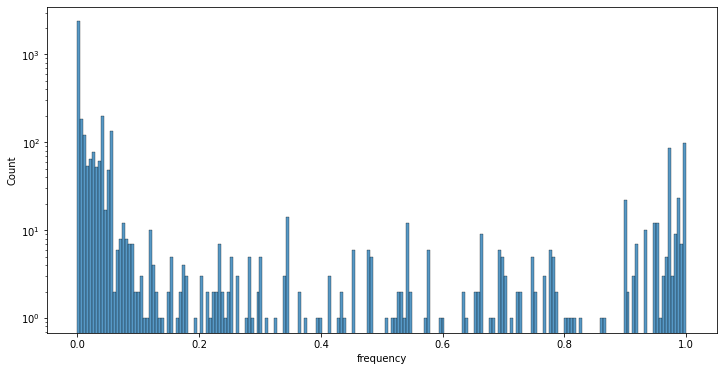

,column,udi,count,type,description,counts,frequency
0,0,eid,502543,Sequence,Encoded anonymised participant ID,9999,1.000000
4,4,31-0.0,502543,Categorical (single),SexUses data-coding 9 comprises 2 Integer-valu...,9999,1.000000
5,5,34-0.0,502543,Integer,Year of birth,9999,1.000000
6,6,35-0.0,501328,Categorical (single),Was blood sampling attemptedUses data-coding 7...,9978,0.997900
9,9,36-0.0,497907,Text,Blood pressure device ID,9907,0.990799
...,...,...,...,...,...,...,...
2718,2718,20117-0.0,501646,Categorical (single),Alcohol drinker statusUses data-coding 90 comp...,9969,0.997000
2734,2734,20160-0.0,499657,Categorical (single),Ever smokedUses data-coding 7 comprises 2 Inte...,9927,0.992799
2743,2743,21000-0.0,501645,Categorical (single),Ethnic backgroundUses data-coding 1001 compris...,9969,0.997000
2746,2746,21003-0.0,502543,Integer,Age when attended assessment centre,9999,1.000000


In [120]:
ukbb_index["counts"] = np.array(ukbb_data.count().tolist())
ukbb_index["frequency"] = ukbb_index["counts"] / len(ukbb_data)
display(ukbb_index.head(10))

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(ukbb_index["frequency"], ax=ax)
ax.set_yscale("log")
plt.show()

display(ukbb_index.query("frequency > .99"))

In [121]:
partial_ukbb_udi_lookup_table = pd.read_csv("resources/core_udi_lookup_table.tsv", sep="\t")
partial_labeled_udis = partial_ukbb_udi_lookup_table.loc[partial_ukbb_udi_lookup_table["name"] != "_"]
partial_udi_to_name_map = dict(zip(partial_labeled_udis["udi"], partial_labeled_udis["name"]))

names = []
for udi in ukbb_index["udi"]:
    if "-" not in udi or udi.endswith("-0.0"):
        names.append(partial_udi_to_name_map.get(udi, None))
    else:
        udi_stem, udi_modifier = udi.split("-")
        primary_udi = udi_stem + "-0.0"
        names.append(f"{partial_udi_to_name_map[primary_udi]}_{udi_modifier}"
                     if primary_udi in partial_udi_to_name_map else None)

ukbb_index["name"] = names
udi_to_name_map = dict(zip(ukbb_index["udi"], ukbb_index["name"]))
name_to_udi_map = dict(zip(ukbb_index["name"], ukbb_index["udi"]))

def get_udi(name):
    if isinstance(name, str):
        return name_to_udi_map.get(name, name)

    return [get_udi(name_i) for name_i in name]

def get_name_from_udi(udi):
    if isinstance(udi, str):
        return udi_to_name_map.get(udi, udi)

    return [get_name_from_udi(udi_i) for udi_i in udi]

In [162]:
ukbb_index["description"].iloc[0]

'Encoded anonymised participant ID'

In [123]:
def relevant_feature_search(ukbb_index: pd.DataFrame, term: str) -> pd.DataFrame:
    """"""
    modified_names = ukbb_index["name"].apply(lambda s: s.replace("_", " ") + " " if s else "")
    descriptions = (modified_names + ukbb_index["description"]).appl
    found_indices = [i for (i, description) in enumerate()
                     if fuzz.partial_ratio(description, term) > 95]
    return ukbb_index.iloc[found_indices]

In [164]:
relevant_feature_search(ukbb_index, "HTN")

,column,udi,count,type,description,counts,frequency,name
760,760,2966-0.0,134649,Integer,Age high blood pressure diagnosedUses data-cod...,2613,0.261326,HTN_dx_age
761,761,2966-1.0,5856,Integer,Age high blood pressure diagnosedUses data-cod...,116,0.011601,HTN_dx_age_1.0
762,762,2966-2.0,7559,Integer,Age high blood pressure diagnosedUses data-cod...,138,0.013801,HTN_dx_age_2.0
1309,1309,6153-0.0,270871,Categorical (multiple),"Medication for cholesterol, blood pressure, di...",5376,0.537654,medications_HLD_HTN_diabetes_HRT
1310,1310,6153-0.1,24598,Categorical (multiple),"Medication for cholesterol, blood pressure, di...",489,0.048905,medications_HLD_HTN_diabetes_HRT_0.1
1311,1311,6153-0.2,2414,Categorical (multiple),"Medication for cholesterol, blood pressure, di...",56,0.005601,medications_HLD_HTN_diabetes_HRT_0.2
1312,1312,6153-0.3,93,Categorical (multiple),"Medication for cholesterol, blood pressure, di...",3,0.000300,medications_HLD_HTN_diabetes_HRT_0.3
1313,1313,6153-1.0,10402,Categorical (multiple),"Medication for cholesterol, blood pressure, di...",214,0.021402,medications_HLD_HTN_diabetes_HRT_1.0
1314,1314,6153-1.1,1076,Categorical (multiple),"Medication for cholesterol, blood pressure, di...",22,0.002200,medications_HLD_HTN_diabetes_HRT_1.1
1315,1315,6153-1.2,92,Categorical (multiple),"Medication for cholesterol, blood pressure, di...",2,0.000200,medications_HLD_HTN_diabetes_HRT_1.2


In [156]:
def udi_wrapper(function, *args, **kwargs) -> Any:
    """"""
    args = {get_udi(arg) for arg in args}
    kwargs = {key: get_udi(value) if isinstance(value, str) else value for key, value in kwargs.items()}
    return function(*args, **kwargs)


def titleize(label: str) -> str:
    """"""
    return label.replace("_", " ").title()


def add_plt_labels(ax, x: str, y: str, **kwargs) -> None:
    ax.set_xlabel(titleize(x))
    ax.set_ylabel(titleize(y))

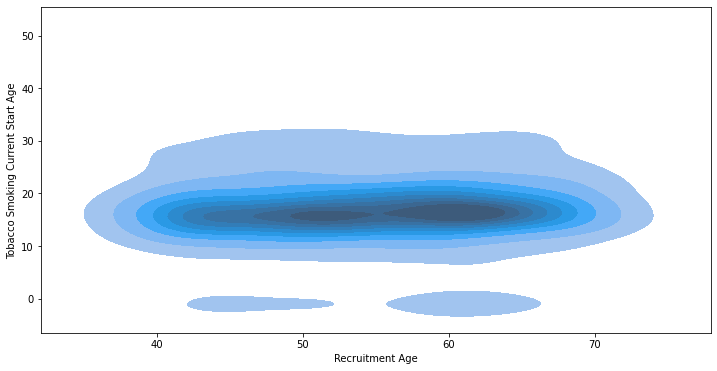

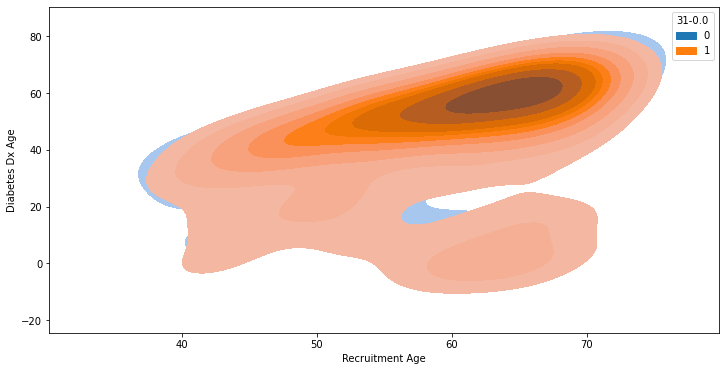

In [152]:
fig, ax = plt.subplots(figsize=(12, 6))
y = "tobacco_smoking_current_start_age"
x = "recruitment_age"
udi_wrapper(sns.kdeplot, data=ukbb_data, y=y, x=x, ax=ax, fill=True)
add_plt_labels(ax, x, y)

y, x = "diabetes_dx_age", "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
ax = udi_wrapper(sns.kdeplot, data=ukbb_data, x=x, y=y, hue="sex", ax=ax, fill=True)
add_plt_labels(ax, x, y)

<AxesSubplot:xlabel='3436-0.0', ylabel='Count'>

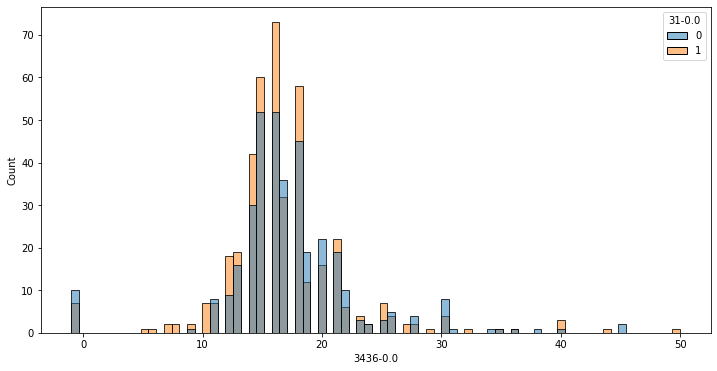

In [153]:
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x="tobacco_smoking_current_start_age", hue="sex",  ax=ax)

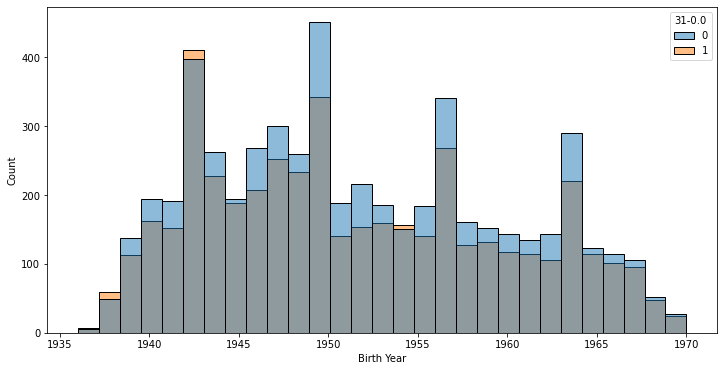

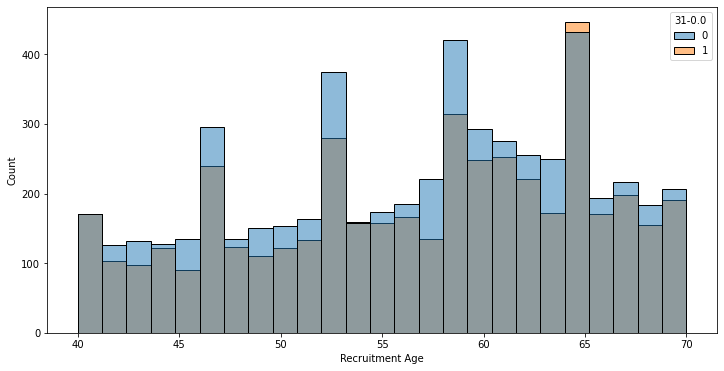

In [161]:

x, hue = "birth_year", "sex"
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")

x = "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
udi_wrapper(sns.histplot, data=ukbb_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")